In [1]:
import pyccl as ccl
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.special import jv as jnu
import sacc

/home/anze/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def GetSliceCorr (Pofk,R,D,nD=10):
    """ Gets correlation of discs of 
        radius R, thickness D for sample with bias and nbar.
        Cosmology object C at redshift z
    """
    ## first integrate in kperp
    kminperp=1e-8
    kmaxperp=10
    kminpar=1e-6
    kmaxpar=100
    kar=np.logspace(np.log(kminpar), np.log(kmaxpar), 1000)
    def KperpIntg (logkperp,kpar):
        kperp=np.exp(logkperp)
        Pk=Pofk(np.sqrt(kpar**2+kperp**2))
        airy=2*jnu(1,kperp*R)/(kperp*R)
        return airy*Pk*(2*np.pi*kperp)*kperp 
    
    def KparIntg (logkpar):
        kpar=np.exp(logkpar)
        Pk=PkparI(kpar)
        sinc = np.sin(kpar*D/2)/(kpar*D/2)  ## -D/2 to + D/2
        return sinc*Pk*kpar*2
    print ("Doing Kperp integration")
    Pkpar = np.array(
        [1/(2*np.pi)**3*quad(lambda lkperp:KperpIntg(lkperp,kpar),np.log(kminperp),np.log(kmaxperp),limit=500)[0] for kpar in kar])
    PkparI=interp1d(kar,Pkpar)
    ## now integrate to 10*D
    Dar=np.arange(nD)*D
    print ("Doing Kpar integration")
    Xi = np.array(
        [quad(KparIntg,np.log(kminpar),np.log(kmaxpar),weight='cos',wvar=dD,limit=500)[0] for dD in Dar]
        )
    return Dar,Xi

In [3]:
## Zero test:
## for P = const, we have Poisson sampling
## so we should just recover the 1/volume
R=200
D=30
nbar=1e-2
Dar,Xi=GetSliceCorr(lambda k:1/nbar, R,D,nD=5)
Nvol=(np.pi*R**2)*D*nbar
assert (Dar[0]==0)
print (1/Xi[0], Nvol, 1/Xi[0]/Nvol)

Doing Kperp integration
Doing Kpar integration
37967.20119025584 37699.11184307752 1.0071112907989515


In [4]:
Xi/Xi[0] ## for poisson sampling it is also true that neighbouring disc should be uncorrelated

array([ 1.        , -0.07843588,  0.04012915, -0.08214597,  0.00168558])

In [5]:
## now let's plug in the linear matter power spectrum and see what happens
C=ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8)
PkInt=lambda k: ccl.linear_matter_power(C,k,1)+1/nbar

In [6]:
Dar,Xi=GetSliceCorr(PkInt, R,D,nD=5)

Doing Kperp integration
Doing Kpar integration


/home/anze/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [7]:
print(Xi)
print(Xi/Xi[0]) ## in slices of 30 Mpc the scross-corr is completelly negligible.

[ 8.51610315e-03 -3.73461808e-06  1.12986481e-06 -2.13147729e-06
  4.75112972e-08]
[ 1.00000000e+00 -4.38536031e-04  1.32673923e-04 -2.50287866e-04
  5.57899503e-06]


In [8]:
## Now imagine the universe to be sliced in 30 Mpc discs.
zar=np.linspace(0,3.0,1000)
Di=ccl.comoving_radial_distance(C,1/(1+zar))
DtoZ=interp1d(Di,zar)

In [9]:
## now create array of discks
dar, zar, ddistdz = [], [], []
cD,cZ=0,0
while cZ<2.5:
    dar.append(cD)
    cZ=float(DtoZ(cD))
    zar.append(cZ)
    ddistdz.append(3e3/(C['h']*ccl.h_over_h0(C,1/(1+cZ))))
    cD+=D
dar=np.array(dar)
zar=np.array(zar)
ddistdz=np.array(ddistdz)

In [10]:
sc=sacc.SACC.loadFromHDF('/home/anze/work/LSST/HSC_ceci/WIDE_GAMA09H_sirius_out/covana_noiana_msksirius_wssc_msksyst0_dpj0_dpb_bands1/power_spectra_wdpj.sacc')

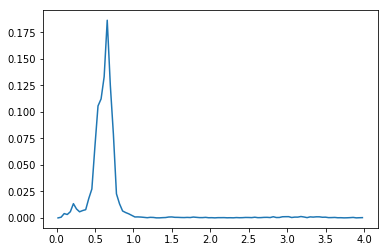

In [11]:
tr=sc.tracers[1]
plt.plot(tr.z,tr.Nz)

In [12]:
## we need to interpolate this onto the grid of 30MPc disks, taking jacobian into account
nzi=interp1d(tr.z,tr.Nz,fill_value=0,bounds_error=False)
Nzd=nzi(zar)/ddistdz
sig=np.sqrt(Xi[0])*0.95 ## note bias = 0.95/g**2 and we have here bias**2 * g**2 so it cancels, we ignore nbar here but small
mz=(Nzd*zar).sum()/Nzd.sum()
sigz=np.sqrt((Nzd*zar**2).sum()/Nzd.sum()-mz**2)
print('mean z=',mz,'sigma z=',sigz)

mean z= 0.6239734314386444 sigma z= 0.1885013943403559


(0.0, 1.0)

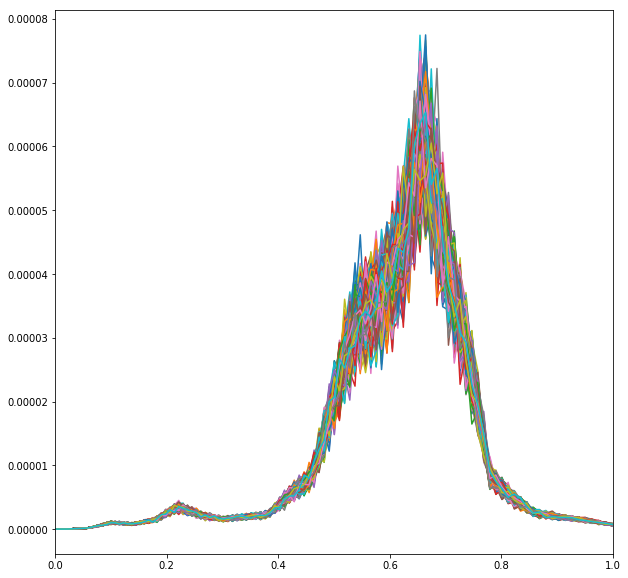

In [13]:
Ng=1000
plt.figure(figsize=(10,10))
mcmz,mcsig=[],[]
for i in range(Ng):
    Nzdc=Nzd*(1+np.random.normal(0,sig,len(Nzd)))
    plt.plot(zar,Nzdc)
    mzx=(Nzdc*zar).sum()/Nzdc.sum()
    sigzx=np.sqrt((Nzdc*zar**2).sum()/Nzdc.sum()-mzx**2)
    mcmz.append(mzx)
    mcsig.append(sigzx)
plt.xlim(0.0,1.0)

(array([ 2.,  2.,  3.,  8.,  9., 15., 19., 24., 21., 28., 30., 29., 42.,
        59., 66., 50., 50., 56., 64., 44., 60., 48., 49., 40., 32., 21.,
        35., 29., 13.,  6., 16., 12.,  1.,  5.,  3.,  1.,  1.,  1.,  0.,
         1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.185 , 0.1852, 0.1854, 0.1856, 0.1858, 0.186 , 0.1862, 0.1864,
        0.1866, 0.1868, 0.187 , 0.1872, 0.1874, 0.1876, 0.1878, 0.188 ,
        0.1882, 0.1884, 0.1886, 0.1888, 0.189 , 0.1892, 0.1894, 0.1896,
        0.1898, 0.19  , 0.1902, 0.1904, 0.1906, 0.1908, 0.191 , 0.1912,
        0.1914, 0.1916, 0.1918, 0.192 , 0.1922, 0.1924, 0.1926, 0.1928,
        0.193 , 0.1932, 0.1934, 0.1936, 0.1938, 0.194 , 0.1942, 0.1944,
        0.1946, 0.1948, 0.195 ]),
 <a list of 50 Patch objects>)

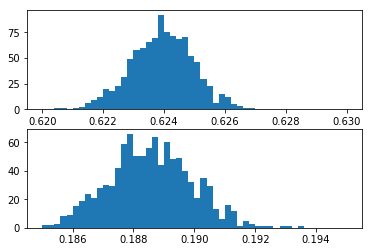

In [14]:
plt.subplot(2,1,1)
plt.hist(mcmz,bins=50,range=(0.62,0.63))
plt.subplot(2,1,2)
plt.hist(mcsig,bins=50,range=(0.185,0.195))